In [1]:
import pickle 
import numpy as np


In [2]:
with open("D:/train_data.pkl","rb") as f:
    train_data=pickle.load(f)

In [3]:
np.shape(train_data)

(5216, 224, 224, 3)

In [4]:
type(train_data)

list

In [5]:
train_data=np.array(train_data)

In [6]:
np.shape(train_data)

(5216, 224, 224, 3)

In [7]:
with open("D:/test_data.pkl","rb") as f:
    test_data=pickle.load(f)
with open("D:/val_data.pkl","rb") as f:
    val_data=pickle.load(f)
with open("D:/train_labels.pkl","rb") as f:
    train_label=pickle.load(f)
with open("D:/test_labels.pkl","rb") as f:
    test_label=pickle.load(f)
with open("D:/val_labels.pkl","rb") as f:
    val_label=pickle.load(f)


In [8]:
np.shape(test_data)


(624, 224, 224, 3)

In [9]:
test_data=np.array(test_data)

In [10]:
np.shape(val_data)

(16, 224, 224, 3)

In [11]:
val_data=np.array(val_data)

In [12]:
train_label=np.array(train_label)

In [13]:
test_label=np.array(test_label)

In [14]:
val_label=np.array(val_label)

In [15]:
np.size(train_label[(train_label==0)])

1341

In [16]:
np.size(train_label[(train_label==1)])

3875

In [17]:
np.size(val_label)

16

In [18]:
np.size(test_label)

624

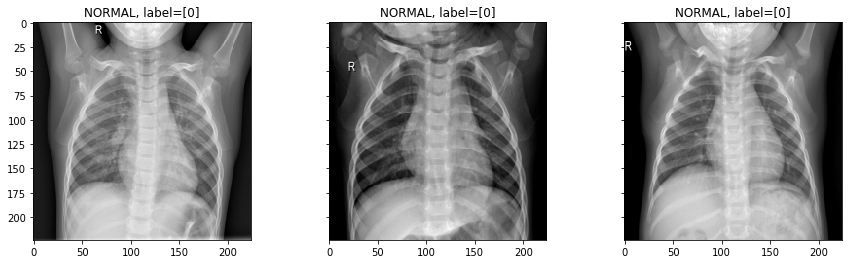

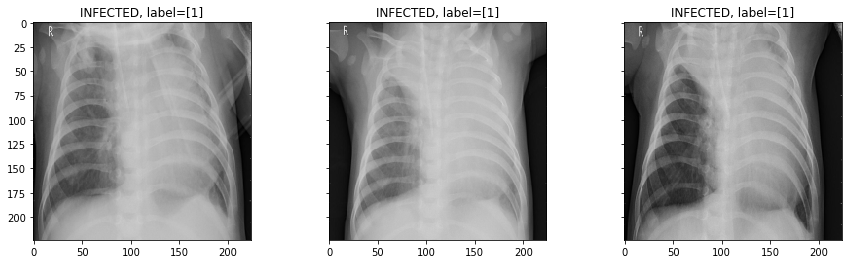

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline 
fig, axs = plt.subplots(1,3,figsize=(15, 4),sharey=True)
for i in range(3):
    axs[i].imshow(train_data[i])
    axs[i].set_title(f"NORMAL, label={train_label[i]}")
fig, axs = plt.subplots(1,3,figsize=(15, 4),sharey=True)
for i,z in enumerate(range(3000,3003)):
    axs[i].imshow(train_data[z])
    axs[i].set_title(f"INFECTED, label={train_label[z]}")
    
plt.show()    

In [20]:
def compute_class_freqs(labels):
    
    N=np.size(labels)
    
    positive_frequencies =np.sum(labels)/N
    negative_frequencies =1-positive_frequencies

    return positive_frequencies, negative_frequencies

In [21]:
pos_freq,neg_freq=compute_class_freqs(train_label)

In [22]:
pos_weight=neg_freq
pos_weight

0.2570935582822086

In [23]:
neg_weight=pos_freq
neg_weight

0.7429064417177914

In [24]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model


In [25]:
vgg = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

W0610 22:30:59.217842  9136 deprecation.py:506] From C:\Users\Gurdeep Singh\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [26]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [27]:
for layer in vgg.layers:
    layer.trainable = False

In [28]:
x = Flatten()(vgg.output)

In [29]:
prediction = Dense(1, activation='sigmoid')(x)



In [30]:
model = Model(inputs=vgg.input, outputs=prediction)

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [32]:
from keras import backend as K

Using TensorFlow backend.


In [33]:

def get_weighted_loss(pos_weight, neg_weight, epsilon=1e-7):

    def weighted_loss(y_true, y_pred):
        
        loss = 0.0

        loss =K.mean(-(pos_weight*y_true* K.log(y_pred + epsilon) 
                             + neg_weight* (1 - y_true) * K.log( 1 - y_pred + epsilon)))
        print(y_true)
        
        return loss
    
    return weighted_loss

In [34]:
model.compile(
  loss=get_weighted_loss(pos_weight,neg_weight),
  optimizer='adam',
  metrics=['accuracy']
)

W0610 22:31:40.555105  9136 deprecation_wrapper.py:119] From C:\Users\Gurdeep Singh\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:1521: The name tf.log is deprecated. Please use tf.math.log instead.



Tensor("dense_target:0", shape=(?, ?), dtype=float32)


In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(rescale=1./225,
                                shear_range=0.2,
                                 zoom_range=0.2)

test_datagen=ImageDataGenerator(rescale=1./225)

In [36]:
training_set=train_datagen.flow(train_data,train_label)

In [37]:
test_set=test_datagen.flow(val_data,val_label)

In [38]:
history=model.fit_generator(
         training_set,
        validation_data=test_set,
        epochs=2,
        verbose=1
     )

Epoch 1/2
163/163 [==============================] - 1768s 11s/step - loss: 0.0675 - acc: 0.9287 - val_loss: 0.0810 - val_acc: 0.9375
Epoch 2/2
163/163 [==============================] - 1759s 11s/step - loss: 0.0491 - acc: 0.9505 - val_loss: 0.0867 - val_acc: 0.8750


In [41]:
model.evaluate(test_data,test_label)

624/624 [==============================] - 203s 325ms/sample - loss: 1.2883 - acc: 0.8542


[1.28831128502112, 0.8541667]

In [42]:
test_data=test_data/255

In [46]:
model.evaluate(test_data,test_label)

624/624 [==============================] - 204s 326ms/sample - loss: 0.1263 - acc: 0.9247


[0.126299233844456, 0.92467946]

In [47]:
val_data=val_data/255

In [48]:
model.evaluate(val_data,val_label)

16/16 [==============================] - 5s 328ms/sample - loss: 0.1264 - acc: 0.8750


[0.12637323141098022, 0.875]

In [49]:
test_label[4]

array([0])

In [50]:
model.predict(test_data[4:5])

array([[0.00326861]], dtype=float32)

In [51]:
test_label[400]

array([1])

In [52]:
model.predict(test_data[400:401])

array([[0.9999367]], dtype=float32)

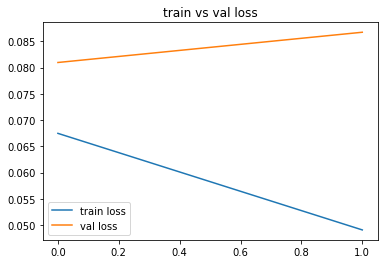

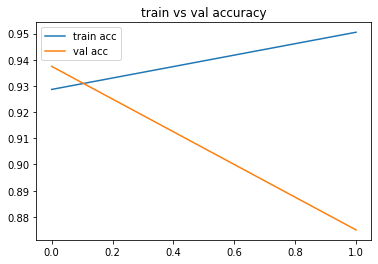

<Figure size 432x288 with 0 Axes>

In [45]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title("train vs val loss")
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['acc'], label='train acc')
plt.plot(history.history['val_acc'], label='val acc')
plt.title("train vs val accuracy")
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [53]:
pred=model.predict(test_data)


In [43]:
from tensorflow.keras.models import Model,load_model

In [68]:
model.save("D:/pneumonia_detector.h5")

In [54]:
pred[:10]

array([[0.00844622],
       [0.00614136],
       [0.01119259],
       [0.00840509],
       [0.0032686 ],
       [0.02043831],
       [0.12576616],
       [0.16382846],
       [0.25722116],
       [0.0698323 ]], dtype=float32)

In [55]:
pred2=pred.copy()

In [56]:
for i,x in enumerate(pred2):
    if pred2[i]<0.5:
        pred2[i]=0;
    else:
        pred2[i]=1
        

In [57]:
pred[:20]

array([[0.00844622],
       [0.00614136],
       [0.01119259],
       [0.00840509],
       [0.0032686 ],
       [0.02043831],
       [0.12576616],
       [0.16382846],
       [0.25722116],
       [0.0698323 ],
       [0.0026046 ],
       [0.03672317],
       [0.01934543],
       [0.01473555],
       [0.01677048],
       [0.01111659],
       [0.9750968 ],
       [0.04597768],
       [0.0029673 ],
       [0.01435274]], dtype=float32)

In [58]:
pred2[:20]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [59]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(test_label,pred2)
cm

array([[202,  32],
       [ 15, 375]], dtype=int64)

Text(0.5, 1, 'confusion matrix')

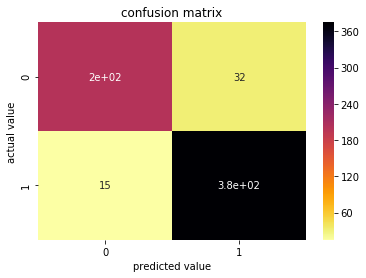

In [60]:
import seaborn as sn
sn.heatmap(cm,annot=True,cmap="inferno_r")
plt.ylabel("actual value")
plt.xlabel("predicted value")
plt.title("confusion matrix")


In [49]:
model=load_model("D:/pneumonia_detector.h5",custom_objects={"loss":get_weighted_loss},compile=False)

In [50]:
'''model.compile(
  loss=get_weighted_loss(pos_weight,neg_weight),
  optimizer='adam',
  metrics=['accuracy']
)'''

Tensor("dense_target_1:0", shape=(?, ?), dtype=float32)


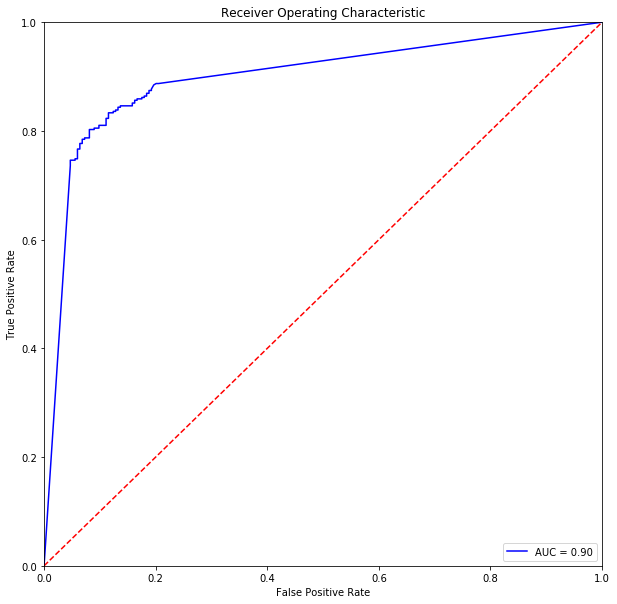

In [79]:
import sklearn.metrics as metrics
probs = model.predict(test_data)
preds = probs
fpr, tpr, threshold = metrics.roc_curve(test_label, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(10,10))
plt.title("Receiver Operating Characteristic")
plt.plot(fpr, tpr,"b", label = "AUC = %0.2f" % roc_auc)
plt.legend(loc ="lower right")
plt.plot([0, 1], [0, 1],"r--")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

In [61]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(np.size(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [63]:
TP, FP, TN, FN=perf_measure(test_label,pred2)

In [64]:
# Sensitivity or true positive rate
sensitivity = TP/(TP+FN)
# Specificity or true negative rate
specificity = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)

In [65]:
sensitivity

0.9615384615384616

In [66]:
specificity

0.8632478632478633

In [67]:
PPV

0.9213759213759214